In [ ]:

print("Let it begin boys")
!pip install -q --upgrade pip
!pip install -q torch torchvision torchaudio
!pip install -q diffusers transformers accelerate
!pip install -q peft bitsandbytes datasets safetensors
!pip uninstall -y protobuf tensorflow
!pip install protobuf==3.20.3
!pip install diffusers transformers accelerate peft safetensors
!pip install -U peft

print("\n" + "="*80)
print("Verification")
print("="*80)

import torch
import diffusers
import transformers
import bitsandbytes

print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ Diffusers: {diffusers.__version__}")
print(f"✓ Transformers: {transformers.__version__}")
print(f"✓ CUDA: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

print("good to go!")

In [ ]:
print("importing stuff")
import os, gc, json, time, math
from pathlib import Path
from dataclasses import dataclass, asdict
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
import torchvision.transforms as T

In [ ]:
# Dataset tool
from datasets import load_dataset
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

In [ ]:
#Print the version info and all
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

In [ ]:
# Hugging Face & PEFT
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    DDPMScheduler,
    StableDiffusionXLPipeline
)
from transformers import CLIPTokenizer, CLIPTextModel, CLIPTextModelWithProjection

In [ ]:
import os

# Define the path on Kaggle
drive_model_path = "/kaggle/working/sdxl-base-1.0"
os.makedirs(drive_model_path, exist_ok=True)

print(f"Downloading and saving base model to: {drive_model_path}")

# Define model ID
model_id = "stabilityai/stable-diffusion-xl-base-1.0"


In [ ]:
print("Saving Tokenizers...")
CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer").save_pretrained(f"{drive_model_path}/tokenizer")
CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer_2").save_pretrained(f"{drive_model_path}/tokenizer_2")





print("Saving Scheduler...")
DDPMScheduler.from_pretrained(model_id, subfolder="scheduler").save_pretrained(f"{drive_model_path}/scheduler")


In [ ]:
print("Saving Text Encoders...")
CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=torch.float16).save_pretrained(f"{drive_model_path}/text_encoder")
CLIPTextModelWithProjection.from_pretrained(model_id, subfolder="text_encoder_2", torch_dtype=torch.float16).save_pretrained(f"{drive_model_path}/text_encoder_2")

In [ ]:
print("Saving VAE...")
AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=torch.float32).save_pretrained(f"{drive_model_path}/vae")

In [ ]:
print("Saving UNet")
UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=torch.float16).save_pretrained(f"{drive_model_path}/unet")

In [ ]:
#training configurations
@dataclass
class TraininigConfiguration:
  modelId: str = "/kaggle/working/sdxl-base-1.0"
  datasetId: str = "lambdalabs/naruto-blip-captions"
  #establish the output directories where we will have output, logs and checkpoints
  outputDir: str = "/kaggle/working/Naruto_FineTune/output"
  logsDir: str = "/kaggle/working/Naruto_FineTune/logs"
  checkpointsDir: str = "/kaggle/working/Naruto_FineTune/checkpoints"
  #Training Hyperparamters
  resolution: int = 512
  train_batch_size: int = 1 #in docs
  gradient_accumulation_steps: int = 4
  num_train_epochs: int = 3
  learning_rate: float = 1e-4
  learning_rate_warmup_steps: int = 10
  learning_rate_scheduler_type: str = "cosine"


  # Optimizations
  mixed_precision: str = "fp16"
  grad_checkpointing : bool = False
  use_8bit_adam: bool = True
  max_grad_norm: float = 1.0

  #For a quick dry run let us set some dataset limits that will be used later
  max_train_samples: int = 150
  seed: int = 42

  #checkpoints
  save_every_step = 250

  #peft;
  # PEFT (LoRA/DoRA)
  lora_rank: int = 16
  lora_alpha: int = 32
  lora_dropout: float = 0.1
  lora_target_modules: tuple = ("to_q","to_k","to_v","to_out.0")
  use_dora = True

  #debug
  debug: bool = True
  dry_run_steps: int = 15
  mini_dataset_mode: bool = False #do set to false when you have to for the entire dataset for the final fine tuning

config = TraininigConfiguration()

In [ ]:
# Dataset and dataloader prep
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode

In [ ]:
ds = load_dataset(config.datasetId, split = "train")
if config.mini_dataset_mode:
    print(f"Training using the mini dataset as the mini dataset mode is set to true in the config and we weiil use the first {config.max_train_samples} samples out of {len(ds)}")
    ds = ds.select(range(config.max_train_samples))


In [ ]:
if config.max_train_samples is not None:
    raw_ds = ds.select(range(min(config.max_train_samples, len(ds))))
print(f"Dataset size: {len(ds)}")


In [ ]:
example_of_dataset = ds[0]
print('it looks something like this', example_of_dataset)

In [ ]:
print('it looks something like this', example_of_dataset.keys())

In [ ]:
print('it looks something like this', example_of_dataset.get('text'))

In [ ]:
#Tokenizers
tokenizer_one = CLIPTokenizer.from_pretrained(config.modelId, subfolder="tokenizer")
tokenizer_two = CLIPTokenizer.from_pretrained(config.modelId, subfolder="tokenizer_2")
print("Tokenizers loaded.")

In [ ]:
#Dataset class
class DatasetOfNaruto(Dataset):
  def __init__(self,hf_dataset,tokenizer_one,tokenizer_two, resolution=512):
    self.ds = hf_dataset
    self.tokenizer_1 = tokenizer_one
    self.tokenizer_2 = tokenizer_two
    self.resolution= resolution
    self.transform = T.Compose([
      T.Resize((resolution, resolution), interpolation=InterpolationMode.BILINEAR),
      T.CenterCrop((resolution, resolution)),
      T.RandomHorizontalFlip(p=0.5),
      T.ToTensor(),
      T.Normalize([0.5]*3, [0.5]*3)
    ])

  def __len__(self):
    return len(self.ds)

  def tokenizer_captions(self,text):
    tok_caption_1 = self.tokenizer_1(text, padding="max_length", truncation=True, max_length=self.tokenizer_1.model_max_length, return_tensors="pt")
    tok_caption_2 = self.tokenizer_2(text, padding="max_length", truncation=True, max_length=self.tokenizer_2.model_max_length, return_tensors="pt")
    return tok_caption_1.input_ids.squeeze(0), tok_caption_2.input_ids.squeeze(0)

  def __getitem__(self,idx):
    item = self.ds[idx]
    img = item["image"]
    pixel_values = self.transform(img)
    caption = item.get("text") or item.get("caption") or item.get("title") or ""
    ids1, ids2 = self.tokenizer_captions(caption)
    return {"pixel_values": pixel_values, "input_ids_one": ids1, "input_ids_two": ids2, "caption": caption}


In [ ]:
#dataset and dataloader
train_ds = DatasetOfNaruto(ds, tokenizer_one, tokenizer_two, resolution=config.resolution)
train_loader = DataLoader(train_ds, batch_size=config.train_batch_size, shuffle = True, num_workers = 2, pin_memory=True)


In [ ]:
print("Dataloader ready. Number of batches per epoch:", len(train_loader))

In [ ]:
batch = next(iter(train_loader))
print("Batch keys:", batch.keys())
print("Pixel values shape:", batch["pixel_values"].shape)
print("Caption (first):", batch["caption"][0])

In [ ]:
#Load the models
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from transformers import CLIPTextModel, CLIPTextModelWithProjection

In [ ]:
#load the text encoders
text_encoder_1 = CLIPTextModel.from_pretrained(config.modelId, subfolder="text_encoder", torch_dtype = torch.float16, device_map="cpu")
text_encoder_2 = CLIPTextModel.from_pretrained(config.modelId, subfolder="text_encoder_2", torch_dtype = torch.float16, device_map="cpu")


In [ ]:
acc = Accelerator(
    gradient_accumulation_steps = config.gradient_accumulation_steps,
    mixed_precision=config.mixed_precision,
)

In [ ]:
vae = AutoencoderKL.from_pretrained(
    config.modelId,
    subfolder="vae",
    torch_dtype=torch.float32,   # MUST be float32
)
vae.requires_grad_(False)
vae.to(acc.device) #to be noted that this VAE is the worst piece of thing ever - needs to be trained on the gpu but make sure that the dtype is float32 and not 16 -> this will cause mismatch error in data types if you do this -> personal notes

In [ ]:
unet = UNet2DConditionModel.from_pretrained(config.modelId, subfolder="unet", torch_dtype=torch.float16, device_map="cpu")


In [ ]:
#noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(config.modelId, subfolder="scheduler")

In [ ]:
#now we will freeze te1, te1 and vae
for p in text_encoder_1.parameters():
  p.requires_grad=False
for p in text_encoder_2.parameters():
  p.requires_grad=False

for p in vae.parameters():
  p.requires_grad=False



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def cuda_mem_report(prefix=""):
    torch.cuda.empty_cache()
    gc.collect()
    if torch.cuda.is_available():
        print(f"{prefix} Allocated: {torch.cuda.memory_allocated() / 1e9:.3f} GB | Reserved: {torch.cuda.memory_reserved() / 1e9:.3f} GB")
    else:
        print(f"{prefix} No CUDA available")

cuda_mem_report("After imports:")

In [ ]:
try:
    print("Moving Unet to GPU")
    unet.to(device=device)
    cuda_mem_report("After moving UNet:")
except RuntimeError as e:
    print("Well damn, out of memory error!!!!!!!!!!", e)
    unet.to(device="cpu")

In [ ]:
for name, param in unet.named_parameters():
    if "norm" in name:
        param.data = param.data.to(torch.float32)

In [ ]:
# ... load unet ...

# --- CLEAN UP MANUAL FIXES ---
# 1. Remove/Comment the manual float32 cast loop
# for name, param in unet.named_parameters(): ... (DELETE THIS)

# 2. Ensure Checkpointing is DISABLED
# unet.enable_gradient_checkpointing() # <--- COMMENT THIS OUT OR DELETE IT

print("✅ UNet loaded. Gradient Checkpointing DISABLED for DoRA stability.")

In [ ]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

In [ ]:
# Apply PEFT techniques to the model - https://huggingface.co/docs/peft/en/package_reference/lora
print("LORAAAAAAAAA")
#Build LoraConfig
lora_config=LoraConfig(
    r=config.lora_rank,
    lora_alpha= config.lora_alpha,
    target_modules = list(config.lora_target_modules),
    lora_dropout = config.lora_dropout,
    bias="none",
    use_dora=True

)

In [ ]:
unet = get_peft_model(unet, lora_config)

In [ ]:
trainable_after = sum(p.numel() for p in unet.parameters() if p.requires_grad)
total_after = sum(p.numel() for p in unet.parameters())
print(f"UNet trainable params after PEFT: {trainable_after:,} / {total_after:,} ({100*trainable_after/total_after:.4f}%)")


In [ ]:
#oprtimizer and scheduler
from transformers import get_scheduler

In [ ]:
device = acc.device
print("Accelerator device:", device)

In [ ]:
import bitsandbytes as bnb

In [ ]:
if config.use_8bit_adam:
  import bitsandbytes as bnb
  optm = bnb.optim.AdamW8bit(unet.parameters(), lr=config.learning_rate)

In [ ]:
# Scheduler
num_update_steps_per_epoch = math.ceil(len(train_loader) / config.gradient_accumulation_steps)
max_train_steps = config.num_train_epochs * num_update_steps_per_epoch
lr_scheduler = get_scheduler(
    config.learning_rate_scheduler_type,
    optimizer=optm,
    num_warmup_steps=config.learning_rate_warmup_steps,
    num_training_steps=max_train_steps
)

In [ ]:
text_encoder_1.to(acc.device)
text_encoder_2.to(acc.device)
# safety: use same dtype as training
text_encoder_1.to(torch.float16)
text_encoder_2.to(torch.float16)
text_encoder_1.eval()
text_encoder_2.eval()
vae.eval()
for p in vae.parameters():
    p.requires_grad = False

In [ ]:
def model_loss(unet_model, vae_model, te1, te2, noise_scheduler, batch):
    device = acc.device
    target_dtype = torch.float16 if config.mixed_precision == "fp16" else torch.float32

    # 1. Input Prep
    # Move pixels to GPU, but keep in float32 for the VAE
    pixel_values = batch["pixel_values"].to(device=device, dtype=torch.float32)
    pixel_values = torch.nan_to_num(pixel_values, nan=0.0, posinf=1.0, neginf=0.0)
    pixel_values = pixel_values.clamp(-1.0, 1.0)

    input_ids_one = batch["input_ids_one"].to(device)
    input_ids_two = batch["input_ids_two"].to(device)

    with torch.no_grad():
        # 2.VAE Encoding
        # Disable autocast to force the VAE to run in full float32 -> was giving main pain tbh
        with torch.autocast(device.type, enabled=False, dtype=torch.float32):
            enc = vae_model.encode(pixel_values)
        #the above snippet will make sure that VAE runs on the GPU with float32!

        if hasattr(enc, "latent_dist"):
            latents = enc.latent_dist.sample()
        elif isinstance(enc, torch.Tensor):
            latents = enc
        else:
            raise RuntimeError(f"Unexpected VAE.encode return type: {type(enc)}")

        # Latents are now on GPU in fp32.
        # Scale and DOWNCAST them to fp16 for the UNet.
        latents = (latents * vae_model.config.scaling_factor).to(dtype=target_dtype)
        #scaled down using `latents*vae_model.config.scaling.factor` -> output is stll in float32
        #target_dtype is float16 so .to() converts the above to that

        # 3. text Encoding
        # This will run in fp16 due to the accelerator's autocast
        out1 = te1(input_ids_one, output_hidden_states=True)
        out2 = te2(input_ids_two, output_hidden_states=True)

        # penultimate hidden states
        emb1 = out1.hidden_states[-2]
        emb2 = out2.hidden_states[-2]

        # correct pooled embedding
        if hasattr(out2, "text_embeds"):
            pooled_emb2 = out2.text_embeds
        else:
            pooled_emb2 = out2.hidden_states[-1][:, 0, :]
            #pooled emb represents the sentecne as a whole and gives model a high level summary of the things

        encoder_hidden_states = torch.cat([emb1, emb2], dim=-1)
        #CLIP -> smaller model but efficent and OpenCLIP -> detailed and nuanced understanding of stuff --->> both get combined to give the model a better understanding of things

    # Get batch size after VAE/Text encoding
    bsz = latents.shape[0]

    # 4. Noise and timesteps
    noise = torch.randn_like(latents)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=device).long()
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

    if config.debug:
        # quick checks
        if encoder_hidden_states.shape[0] != bsz:
            raise RuntimeError("Batch size mismatch between latents and text embeddings.")
        if torch.isnan(encoder_hidden_states).any():
            raise RuntimeError("NaN detected in encoder_hidden_states.")

    # 5. Conditioning
    # `add_time_ids` must match the dtype of the text embeddings (fp16)
    add_time_ids = torch.tensor(
        [[config.resolution, config.resolution, 0, 0, config.resolution, config.resolution]] * bsz,
        device=device,
        dtype=target_dtype # <-- CHANGED (from torch.long)
    )
    added_cond_kwargs = {"text_embeds": pooled_emb2, "time_ids": add_time_ids}

    # UNet - forward pass
    model_out = unet_model(noisy_latents, timesteps, encoder_hidden_states, added_cond_kwargs=added_cond_kwargs)
    model_pred = model_out.sample if hasattr(model_out, "sample") else model_out


    loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

    if config.debug and (torch.isnan(loss) or torch.isinf(loss)):

        raise RuntimeError(
            "Loss became NaN/Inf. Debug dump: "
            f"model_pred min/max = {float(model_pred.float().min()):.6f}/{float(model_pred.float().max()):.6f}, "
            f"noise min/max = {float(noise.float().min()):.6f}/{float(noise.float().max()):.6f}"
        )
    return loss

In [ ]:
# Dry Run Cell
print("Running single-batch dry-run...")
unet.train()
batch = next(iter(train_loader))

# Enable Autocast (Required for DoRA)
with torch.autocast("cuda"):
    loss = model_loss(unet, vae, text_encoder_1, text_encoder_2, noise_scheduler, batch)
    print("✅ Forward pass successful. Loss:", float(loss.item()))

    print("Running backward pass...")
    acc.backward(loss)

optm.step()
optm.zero_grad()
print("✅ Backward pass successful.")

In [ ]:
from time import time
from tqdm import tqdm
import torch

global_step = 0
unet.train()

print("Deslaab")

for epoch in range(config.num_train_epochs):

    # nice progress bar
    epoch_pbar = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{config.num_train_epochs}",
        disable=not acc.is_main_process
    )

    epoch_loss = 0.0
    steps_in_epoch = 0
    t0 = time()

    for step, batch in enumerate(epoch_pbar):

        with acc.accumulate(unet):
            # --- THE FIX: Wrap Forward & Backward in Autocast ---
            # This allows FP16 weights (UNet) to handle FP32 math (DoRA/Norms)
            with torch.autocast("cuda"):
                loss = model_loss(unet, vae, text_encoder_1, text_encoder_2, noise_scheduler, batch)

                # Keep backward INSIDE the autocast block!
                # This ensures gradients are calculated with the correct precision bridge.
                acc.backward(loss)

            # Gradient clipping (safer)
            if acc.sync_gradients:
                acc.clip_grad_norm_(unet.parameters(), config.max_grad_norm)

            optm.step()
            lr_scheduler.step()
            optm.zero_grad()

        # Only log on sync steps (when optimizer actually stepped)
        if acc.sync_gradients:
            global_step += 1
            steps_in_epoch += 1
            epoch_loss += loss.item()

            # Print every 5 steps (adjust as needed)
            if global_step % 5 == 0 and acc.is_main_process:
                avg_loss = epoch_loss / steps_in_epoch
                curr_lr = lr_scheduler.get_last_lr()[0]
                step_time = (time() - t0) / max(1, steps_in_epoch)

                epoch_pbar.set_postfix({
                    "loss": f"{avg_loss:.4f}",
                    "lr": f"{curr_lr:.2e}",
                    "step_time": f"{step_time:.2f}s"
                })

            # Save checkpoint
            if global_step % config.save_every_step == 0 and acc.is_main_process:
                ckpt_path = f"{config.checkpointsDir}/checkpoint-{global_step}"
                acc.save_state(ckpt_path)
                print(f"Saved checkpoint at: {ckpt_path}\n")
                torch.cuda.empty_cache()

    if acc.is_main_process:
        print(f"Finished Epochhhh {epoch+1}/{config.num_train_epochs} | "
              f"Avg Loss: {epoch_loss/steps_in_epoch:.4f}")

In [ ]:
import os
import gc
import torch

# Save path for Kaggle
final_save_path = "/kaggle/working/Naruto_FineTune/final_weights"
os.makedirs(final_save_path, exist_ok=True)

# Unwrap the accelerator model before saving
unet = acc.unwrap_model(unet)

# Save the LoRA / UNet weights
unet.save_pretrained(final_save_path)

print(f"Final weights saved safely to: {final_save_path}")


print("Cleaning up training models from VRAM...")

try:
    del unet, text_encoder_1, text_encoder_2, vae, optm, acc
except NameError:
    print("Some objects were already deleted.")

torch.cuda.empty_cache()
gc.collect()

print("Training complete and lora weights saved.")
print("Memory cleared. Ready for inference.")


In [ ]:
#inference part

In [2]:
import torch
import gc
import os
from diffusers import StableDiffusionXLPipeline, AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTokenizer, CLIPTextModel, CLIPTextModelWithProjection
from peft import PeftModel
from PIL import Image
from IPython.display import display

# --- KAGGLE CONFIGURATION ---
base_model_path = "/kaggle/working/sdxl-base-1.0"
LORA_WEIGHTS_PATH = "/kaggle/working/Naruto_FineTune/final_weights"

prompts = [
    "Naruto Uzumaki eating ramen",
    "Bill Gates in Naruto style",
    "A boy with blue eyes in Naruto style",
]

# --- HELPER ---
def flush():
    torch.cuda.empty_cache()
    gc.collect()


PROMPT: Naruto Uzumaki eating ramen

 Generating (Original): 'Naruto Uzumaki eating ramen'
   Loading components to GPU...


  0%|          | 0/30 [00:00<?, ?it/s]


 Generating (DoRA Fine-Tuned): 'Naruto Uzumaki eating ramen'
   Loading components to GPU...
   Wrapping UNet with DoRA weights...


  0%|          | 0/30 [00:00<?, ?it/s]


--- RESULT (Left: Original | Right: DoRA Fine-Tuned) ---


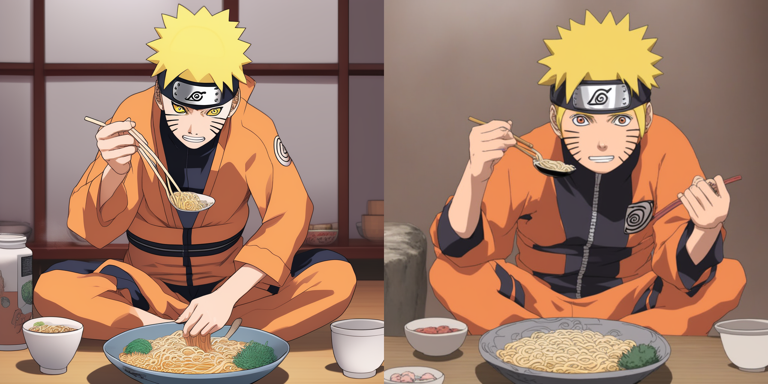


PROMPT: Bill Gates in Naruto style

 Generating (Original): 'Bill Gates in Naruto style'
   Loading components to GPU...


  0%|          | 0/30 [00:00<?, ?it/s]


 Generating (DoRA Fine-Tuned): 'Bill Gates in Naruto style'
   Loading components to GPU...
   Wrapping UNet with DoRA weights...


  0%|          | 0/30 [00:00<?, ?it/s]


--- RESULT (Left: Original | Right: DoRA Fine-Tuned) ---


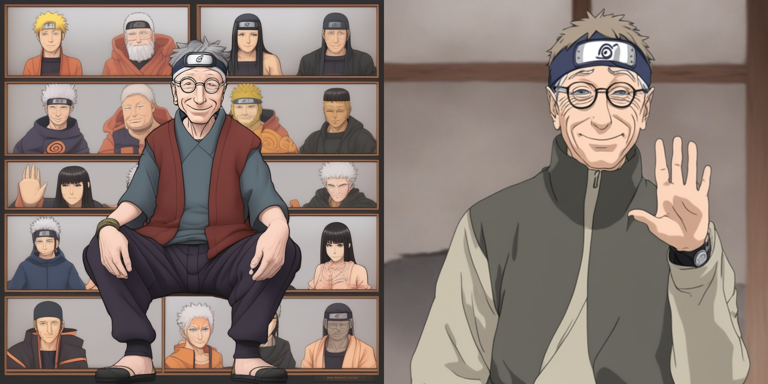


PROMPT: A boy with blue eyes in Naruto style

 Generating (Original): 'A boy with blue eyes in Naruto style'
   Loading components to GPU...


  0%|          | 0/30 [00:00<?, ?it/s]


 Generating (DoRA Fine-Tuned): 'A boy with blue eyes in Naruto style'
   Loading components to GPU...
   Wrapping UNet with DoRA weights...


  0%|          | 0/30 [00:00<?, ?it/s]


--- RESULT (Left: Original | Right: DoRA Fine-Tuned) ---


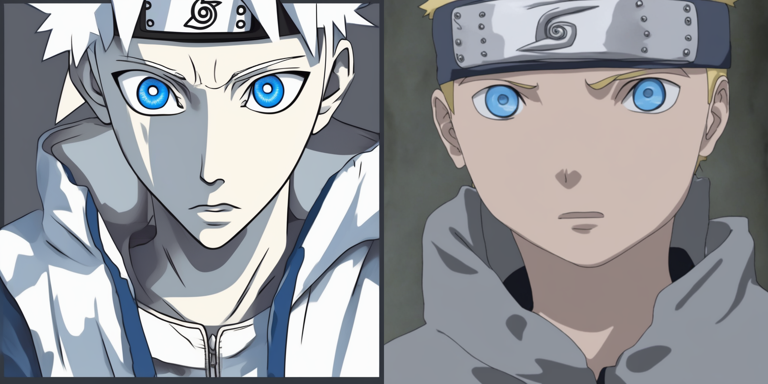

In [3]:
def generate_image(prompt, use_lora=False):
    print(f"\n Generating ({'DoRA Fine-Tuned' if use_lora else 'Original'}): '{prompt}'")
    flush()


    print("   Loading components to GPU...")

    tokenizer = CLIPTokenizer.from_pretrained(base_model_path, subfolder="tokenizer")
    tokenizer_2 = CLIPTokenizer.from_pretrained(base_model_path, subfolder="tokenizer_2")

    # Load and immediately move to CUDA
    text_encoder = CLIPTextModel.from_pretrained(base_model_path, subfolder="text_encoder", torch_dtype=torch.float16, low_cpu_mem_usage=True).to("cuda")
    text_encoder_2 = CLIPTextModelWithProjection.from_pretrained(base_model_path, subfolder="text_encoder_2", torch_dtype=torch.float16, low_cpu_mem_usage=True).to("cuda")
    vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, low_cpu_mem_usage=True).to("cuda")
    unet = UNet2DConditionModel.from_pretrained(base_model_path, subfolder="unet", torch_dtype=torch.float16, low_cpu_mem_usage=True).to("cuda")
    scheduler = DDPMScheduler.from_pretrained(base_model_path, subfolder="scheduler")

    # Assemble Pipeline
    pipe = StableDiffusionXLPipeline(
        vae=vae, text_encoder=text_encoder, text_encoder_2=text_encoder_2,
        tokenizer=tokenizer, tokenizer_2=tokenizer_2, unet=unet, scheduler=scheduler
    )

    # --- OPTIMIZATIONS ---
    # Critical for T4 when loading everything to GPU
    pipe.enable_vae_slicing()
    pipe.enable_attention_slicing() 

    # --- DORA INJECTION ---
    if use_lora:
        try:
            print("   Wrapping UNet with DoRA weights...")
            # For DoRA, we wrap the UNet. We do NOT merge.
            pipe.unet = PeftModel.from_pretrained(pipe.unet, LORA_WEIGHTS_PATH)
            
            # Explicitly move the adapter to CUDA to prevent device mismatch
            pipe.unet.to("cuda") 
            
        except Exception as e:
            print(f"   Error loading DoRA: {e}")
            return None

    # --- GENERATE ---
    generator = torch.Generator("cuda").manual_seed(42)
    
    try:
        image = pipe(
            prompt=prompt,
            num_inference_steps=30,
            guidance_scale=7.5,
            generator=generator
        ).images[0]
    except Exception as e:
        print(f"   Generation failed: {e}")
        return None

    # --- CLEANUP ---
    del pipe, vae, text_encoder, text_encoder_2, unet, tokenizer, tokenizer_2, scheduler
    flush()

    return image

# --- MAIN EXECUTION ---
flush() # Ensure clean start

for prompt in prompts:
    print(f"\n" + "="*50)
    print(f"PROMPT: {prompt}")
    print("="*50)

    # 1. Generate Base
    image_base = generate_image(prompt, use_lora=False)

    # 2. Generate Tuned
    image_tuned = generate_image(prompt, use_lora=True)

    # 3. Compare
    if image_base and image_tuned:
        total_width = image_base.width + image_tuned.width
        combined = Image.new('RGB', (total_width, image_base.height))
        combined.paste(image_base, (0, 0))
        combined.paste(image_tuned, (image_base.width, 0))

        print("\n--- RESULT (Left: Original | Right: DoRA Fine-Tuned) ---")
        display(combined.resize((768, 384)))
    else:
        print("Skipping comparison due to generation failure.")